In [21]:
from torchvision import datasets
import numpy as np
import pandas as pd
from torch import optim
import torch
CUDA_LAUNCH_BLOCKING=1
from torchvision import models
import torch.nn as nn
import os
import tqdm
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import skimage
from skimage.color import rgb2gray, gray2rgb
import cv2
import gc
from sklearn.metrics import mean_squared_error

## Preproc functions : Remove white region | Crop | Normalize

In [22]:
def crop_desired_region(img_):
    '''
    Cropping desired region. 
    RSNA training images contain blank spaces. 
    To remove the region, apply non-zero pixels and cut.
    And then resize to the original size.
    '''
    coords = cv2.findNonZero(img_) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    rect = img_[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    rect_originalSized = cv2.resize(rect,(img_.shape))
    return rect_originalSized

def center_crop(img, set_size):
    h, w, c = img.shape
    if set_size > min(h, w):
        return img
    crop_width = set_size
    crop_height = set_size
    mid_x, mid_y = w//2, h//2
    offset_x, offset_y = crop_width//2, crop_height//2
    crop_img = img[mid_y - offset_y:mid_y + offset_y, mid_x - offset_x:mid_x + offset_x]
    return crop_img

def normalize(img: np.ndarray) -> np.ndarray:
    '''
    Normalize processed image. MinMax.
    '''
    return (img - img.min()) / (img.max() - img.min())

def preproc_tabular(df,root_dir):
    df['filename'] = root_dir+'/'+df.patient_id.astype(str)+'/'+df.image_id.astype(str)+'.png'
    train_selected = df.drop(['patient_id','image_id','cancer','filename','laterality','view'],axis=1)
    train_selected.BIRADS.fillna('7',inplace = True)
    train_selected.BIRADS = train_selected.BIRADS.astype('category')
    train_selected.density.fillna('K',inplace = True)
    train_selected.density = train_selected.density.astype('category')
    train_input = pd.get_dummies(train_selected)
    return(train_input)

def preproc_tabular_test(df,root_dir):
    df['filename'] = root_dir+'/'+df.patient_id.astype(str)+'/'+df.image_id.astype(str)+'.png'
    train_selected = df.drop(['patient_id','image_id','filename','laterality','view'],axis=1)
    train_input = pd.get_dummies(train_selected)
    return(train_input)


def preproc_image(img_name):
    '''
    Foward process of forementioned pre-processes.
    Includes : 
    1. Read 
    2. Remove blank region, resize 
    3. Convert Grayscale to RGB for ResNet18 application ( Just to fit dimension )
    4. Center crop 
    5. Normalize processed image
    6. Convert to Tensor
    7. Permute tensor dimension to make as an input for pretrained model.
    '''
    image = io.imread(img_name)
    image = crop_desired_region(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  
#     image = center_crop(image,100)
    image = normalize(image)
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    return(image)

In [23]:
class RSNADataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.tabular = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        tabular_tmp = self.tabular
        train_input = preproc_tabular(tabular_tmp,self.root_dir)
        img_name = tabular_tmp.filename.tolist()[idx]
        image = preproc_image(img_name)
        target = torch.Tensor(tabular_tmp['cancer'].tolist())[idx]
        sample = {'image': image,'answer':target}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [24]:
class RSNADataset_Test(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.tabular = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        tabular_tmp = self.tabular
        train_input = preproc_tabular_test(tabular_tmp,self.root_dir)
        img_name = tabular_tmp.filename.tolist()[idx]
        image = preproc_image(img_name)
        sample = {'image': image}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [25]:
def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float).cuda() # Tensor for prediction value appending
    actual = torch.tensor([], dtype=torch.float).cuda() # Tensor for answer value appending
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, values = data['image'].float().cuda(),data['answer'].cuda()
            outputs = model(inputs).cuda()
            predictions = torch.cat((predictions, torch.stack([torch.argmax(o) for o in outputs])),0)
            actual = torch.cat((actual, values), 0)
    
    predictions = predictions.cpu().numpy()
    actual = actual.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    return rmse

# Check for pre-processing steps

In [26]:
def show_preproc_image(img_name):
    '''
    Foward process of forementioned pre-processes.
    Includes : 
    1. Read 
    2. Remove blank region, resize 
    3. Convert Grayscale to RGB for ResNet18 application
    4. Center crop 
    5. Normalize processed image
    6. Convert to Tensor
    7. Permute tensor dimension to make as an input for pretrained model.
    '''
    
    plt.figure(figsize = (15,8))
    
    plt.subplot(2,3,1)
    image = io.imread(img_name)
    plt.imshow(image)
    plt.title('Original Image')
    
    plt.subplot(2,3,2)
    image = crop_desired_region(image)
    plt.imshow(image)
    plt.title('Original Image + Cropped')

    plt.subplot(2,3,3)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  
    plt.imshow(image)
    plt.title('Original Image + Cropped + RGB')
    
    plt.subplot(2,3,4)
    image = center_crop(image,100)
    plt.imshow(image)
    plt.title('Original Image + Cropped + RGB + center Crop')

    plt.subplot(2,3,5)
    image = normalize(image)
    plt.imshow(image)
    plt.title('Original Image + Cropped + RGB + center Crop + Normalize')

    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    
    plt.tight_layout()
    return(0)

0

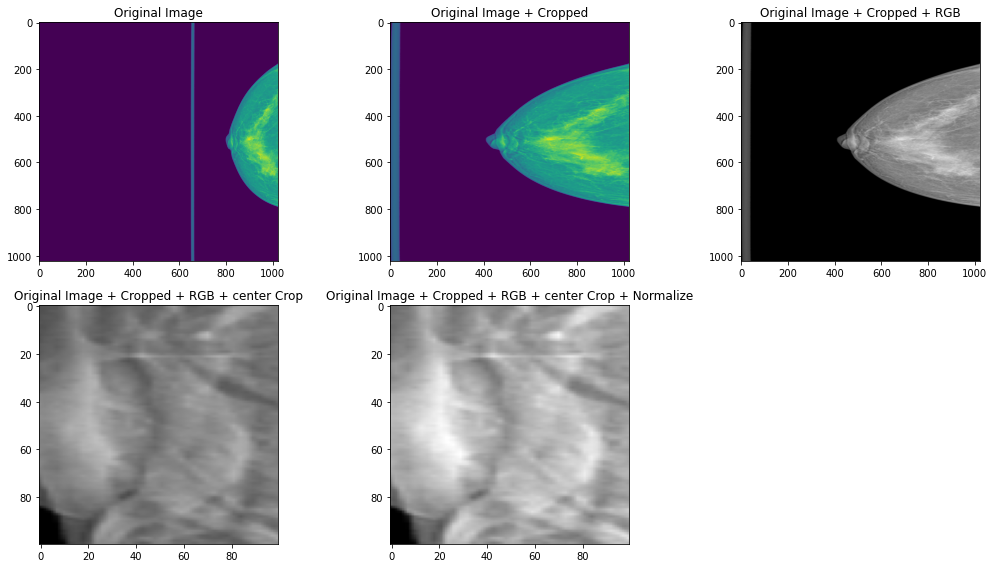

In [27]:
test_file = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/10006/1874946579.png'
show_preproc_image(test_file)

- This seems center crop diminishes characteristics of our image... ( Removed from real preproc function )

In [28]:
lr = 1e-06
num_epochs = 1
batch_size = 4

csv ='/kaggle/input/rsna-breast-cancer-detection/train.csv'
# rootpath = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/'
rootpath = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_256/train_images_processed_cv2_256/'
rsna_dataset = RSNADataset(csv_file=csv,root_dir=rootpath)
# Train-Test split.
train_rsna_set, val_rsna_set = torch.utils.data.random_split(rsna_dataset,[44706,10000])

train_rsna_dataloader = DataLoader(train_rsna_set, batch_size=batch_size, shuffle=True)
val_rsna_dataloader = DataLoader(val_rsna_set, batch_size=batch_size, shuffle=True)


# Model & device & functions & parameters

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True) # Commented because this competition allows no internet usage
# model = torch.load('/kaggle/input/pytorch-pretrained/resnet50-0676ba61.pth')
# model.fc = nn.Sequential(nn.Linear(512,2),nn.Softmax()) # ResNet18
model.fc = nn.Sequential(nn.Linear(2048,2),nn.Softmax()) # ResNet50

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.BCEWithLogitsLoss().to(device)
num_epoch = 1
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_rsna_dataloader,
    'val_dataloader': val_rsna_dataloader,
    'device':device,
    'num_epoch' : num_epoch
}

# Train with KFold

### Load KFold Function by sklearn

In [34]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3, shuffle=True)

In [35]:

# Clear memory in case for GPU memory error
torch.cuda.empty_cache()
gc.collect()

70

### Train with KFold - Visulaize train process with tqdm.

In [36]:
batch_size = 128
soft = nn.Softmax()
model.train()
validation_loss = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_rsna_set)): # Kfold
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx) # Create Index
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx) # Create Index
    
    # Define K-fold dataloader using subsampler
    trainloader = torch.utils.data.DataLoader(train_rsna_set, batch_size=batch_size, sampler=train_subsampler) # 해당하는 index 추출
    valloader = torch.utils.data.DataLoader(train_rsna_set, batch_size=batch_size, sampler=val_subsampler)
    
    loss_function=params["loss_function"]
    train_dataloader=params["train_dataloader"]
    val_dataloader=params["val_dataloader"]
    device=params["device"]
    num_epochs = params['num_epochs']
    
    for epoch in range(0, num_epochs):
        for i_batch,dat in enumerate(tqdm.tqdm(trainloader)):
            inputs = dat['image'].float().cuda()
            labels = dat['answer'].cuda()
            
            optimizer.zero_grad() 
            outputs = model(inputs)
            outputs = torch.stack([torch.argmax(o) for o in outputs])
            
            train_loss = loss_function(outputs.float(),labels.float())
            train_loss = train_loss.requires_grad_(True)
            train_loss.backward()
            optimizer.step()

    train_rmse = evaluation(trainloader) 
    val_rmse = evaluation(valloader)
    print("k-fold", fold," Train Loss: %.4f, Validation Loss: %.4f" %(train_rmse, val_rmse)) 
    validation_loss.append(val_rmse)

validation_loss = np.array(validation_loss)
mean = np.mean(validation_loss)
std = np.std(validation_loss)
print("Validation Score: %.4f, ± %.4f" %(mean, std))

  0%|          | 0/233 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 233/233 [55:21<00:00, 14.25s/it]
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


k-fold 0  Train Loss: 0.1526, Validation Loss: 0.1504


  0%|          | 0/233 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 233/233 [52:56<00:00, 13.63s/it]
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


k-fold 1  Train Loss: 0.1529, Validation Loss: 0.1497


  0%|          | 0/233 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 233/233 [53:22<00:00, 13.75s/it]
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


k-fold 2  Train Loss: 0.1500, Validation Loss: 0.1554
Validation Score: 0.1518, ± 0.0026


# Inference

### Load Test dataset

- Test DICOM to PNG dataset from https://www.kaggle.com/datasets/suhancho/rsna-test-dicomtopng-files

In [37]:
csv_test = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
rootpath_test = '/kaggle/input/rsna-test-dicomtopng-files/Test_DICOM_PNGs/test_images_processed_256/'
rsna_dataset_test = RSNADataset_Test(csv_file = csv_test,root_dir = rootpath_test)
test_rsna_dataloader = DataLoader(rsna_dataset_test, batch_size=batch_size)

In [48]:
output_lst=[]
for i_batch,dat in enumerate(tqdm.tqdm(test_rsna_dataloader)):
    inputs = dat['image'].float().cuda()
    outputs = model(inputs)
    outputs = torch.stack([o[1].cpu() for o in outputs])
    outputs_transform = outputs.detach().numpy()
    

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


In [50]:
submission_base_tab = rsna_dataset_test.tabular
submission_out = pd.DataFrame(outputs_transform)

In [51]:
submission = pd.concat([submission_base_tab,submission_out],axis=1)[['prediction_id',0]]
submission.columns = ['prediction_id','cancer']
submission.to_csv('submission.csv')

In [52]:
submission

,prediction_id,cancer
0,10008_L,0.234279
1,10008_L,0.342749
2,10008_R,0.329711
3,10008_R,0.318454


# Upvote if you liked my notebook!

## Train without KFold

In [ ]:
# def train(model, params):
#     soft = nn.Softmax()
#     loss_function=params["loss_function"]
#     train_dataloader=params["train_dataloader"]
#     val_dataloader=params["val_dataloader"]
#     device=params["device"]
#     for epoch in range(0, num_epochs):
#         for dat in rsna_dataloader:
#             inputs = dat['image'].float().cuda()
#             labels = dat['answer'].cuda()
            
#             optimizer.zero_grad() 
#             outputs = model(inputs)
#             outputs = torch.stack([torch.argmax(o) for o in outputs])
            
#             train_loss = loss_function(outputs.float(),labels.float())
#             train_loss = train_loss.requires_grad_(True)
#             train_loss.backward()
#             optimizer.step()
# #             print('Epoch: %d/%d, Train loss: %.6f' %(epoch+1, num_epochs, train_loss.item()))

#   # Validation accuracy 
#     total = 0
#     correct = 0
#     accuracy = []
#     for i, data in enumerate(val_dataloader, 0):
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         outputs = model(inputs)

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         test_loss = loss_function(outputs, labels).item()
#         accuracy.append(100 * correct/total)    
#         print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f' %(epoch+1, num_epochs, train_loss.item(), test_loss, 100*correct/total))
        
#     import gc
#     torch.cuda.empty_cache()
#     gc.collect()
#     return(0)


# train(model, params)